In [16]:
!pip install -qU uproot ace_tools awkward_pandas

## Data Acquisition

In [2]:
import uproot, pandas as pd, pprint, re, pathlib

root_path = pathlib.Path("~/Desktop/CERN/LHC-aging-analysis/data/laserROOT/o2_ft0digits.root").expanduser()
file = uproot.open(root_path)

# 1️⃣ peek into the o2sim directory
o2sim_dir = file["o2sim"]
print("Keys under o2sim:")
pprint.pp(o2sim_dir.keys())            # should list TTrees like 'FT0Digit', 'CTPHeader', …

# 2️⃣ find a tree that contains the FT0 digits
tree_name = next(k for k in o2sim_dir.keys() if re.search(r"FT0.*Digit", k, re.I))
tree = o2sim_dir[tree_name]
print("Using tree:", tree_name)

# 3️⃣ load branches -> DataFrame
#df = tree.arrays(library="pd")         # or specify columns=["chanId","adc","tfTime"]
#print(df.head())

Keys under o2sim:
['FT0DIGITSBC',
 'FT0DIGITSBC/FT0DIGITSBC.ref.mFirstEntry',
 'FT0DIGITSBC/FT0DIGITSBC.ref.mEntries',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.triggersignals',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.nChanA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.nChanC',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.amplA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.amplC',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.timeA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.timeC',
 'FT0DIGITSBC/FT0DIGITSBC.mEventStatus',
 'FT0DIGITSBC/FT0DIGITSBC.mIntRecord.bc',
 'FT0DIGITSBC/FT0DIGITSBC.mIntRecord.orbit',
 'FT0DIGITSBC/FT0DIGITSBC.mEventID',
 'FT0DIGITSCH',
 'FT0DIGITSCH/FT0DIGITSCH.ChId',
 'FT0DIGITSCH/FT0DIGITSCH.ChainQTC',
 'FT0DIGITSCH/FT0DIGITSCH.CFDTime',
 'FT0DIGITSCH/FT0DIGITSCH.QTCAmpl']
Using tree: FT0DIGITSBC


In [44]:
import json, pathlib, re, math
import numpy as np
import pandas as pd
import uproot, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import awkward as ak

# Paths
DIGIT_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
RUN_JSON  = pathlib.Path("../data/laserROOT/laser_runs.json")

assert DIGIT_DIR.is_dir(), "Digits directory not found"
assert RUN_JSON.is_file(), "runs.json not found"

# Helper: Gaussian model
def gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [45]:
with RUN_JSON.open() as f:
    run_meta = {item["run"]: item["start_ms"] for item in json.load(f)}

print(f"runs.json contains {len(run_meta)} entries")

runs.json contains 228 entries


In [52]:
results     = []
file_re     = re.compile(r"run_(\d+)_ft0digits\.root")
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))
failures = 0

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="processing runs"):
    run = int(file_re.match(root_path.name).group(1))

    # 1) read QTC amplitudes (flatten jagged array)
    with uproot.open(root_path) as f:
        qtc_awk = f["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"].array(library="ak")
    qtc = ak.to_numpy(ak.flatten(qtc_awk))
    if qtc.size == 0:
        continue

    # 2) histogram + peak
    hist, edges  = np.histogram(qtc, bins="auto")
    bins         = 0.5 * (edges[:-1] + edges[1:])
    x_peak       = bins[np.argmax(hist)]        # ADC value at mode

    # 3) adaptive fit window
    for scale in (0.25, 0.35, 0.45, 0.60):
        mask = (bins >= (1 - scale) * x_peak) & (bins <= (1 + scale) * x_peak)
        if (hist[mask] > 0).sum() >= 5:
            x_fit, y_fit = bins[mask], hist[mask]
            break
    else:
        results.append(dict(run=run, start_ms=run_meta.get(run),
                            adc_mip=np.nan, err=np.nan))
        continue

    # 4) Gaussian fit  →  μ̂, σ̂  (may fail)
    try:
        p0 = (y_fit.max(), x_peak, np.std(qtc))
        popt, _ = curve_fit(gauss, x_fit, y_fit, p0=p0, maxfev=8000)
        _, mu, sigma = popt
    except RuntimeError:
        mu, sigma = np.nan, np.nan
        failures = failures + 1

    # 5) **normalise by peak position**
    mu_norm = mu / x_peak if np.isfinite(mu) and x_peak else np.nan
    sigma_norm = sigma / x_peak if np.isfinite(sigma) and x_peak else np.nan

    results.append(dict(run=run,
                        start_ms=run_meta.get(run),
                        adc_mip=mu_norm,
                        err=sigma_norm))

# build DataFrame, discard failed fits
df = (pd.DataFrame(results)
        .dropna(subset=["adc_mip"])
        .sort_values("start_ms"))

print("Result table shape:", df.shape)
print("Failures:", failures)
df.head()

Found 198 ROOT files


processing runs:   0%|          | 0/198 [00:00<?, ?it/s]

Result table shape: (189, 4)
Failures: 0


,run,start_ms,adc_mip,err
0,549661,1712509984000,1.030860,0.113678
1,549749,1712639399000,0.997766,0.116775
2,549824,1712774571000,0.999055,-0.118018
3,549853,1712788504000,0.994662,0.116039
4,549958,1712919188000,0.978508,0.114535


In [53]:
print(df[["adc_mip", "err"]].describe())
print("\nEarliest run :", pd.to_datetime(df['start_ms'], unit='ms').min())
print("Latest run   :", pd.to_datetime(df['start_ms'], unit='ms').max())

          adc_mip         err
count  189.000000  189.000000
mean     1.009128    0.056322
std      0.041902    0.124420
min      0.937589   -0.159639
25%      0.974770   -0.130070
50%      1.001279    0.126968
75%      1.039188    0.137269
max      1.114365    0.160137

Earliest run : 2024-04-07 17:13:04
Latest run   : 2025-07-14 02:54:44.829000


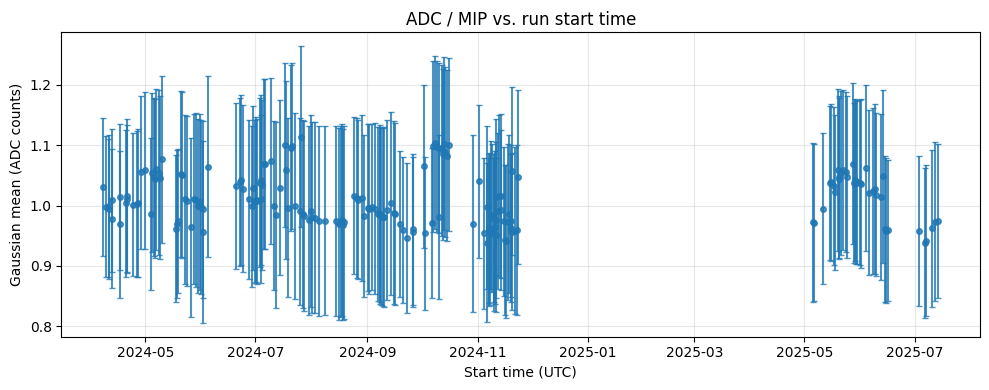

In [62]:
plt.figure(figsize=(10, 4))

# 1) keep only rows with a finite, positive σ
plot_df = df[np.isfinite(df["err"])].copy()
plot_df["err"] = plot_df["err"].abs()         # force positivity

# 2) convert ms → pandas datetime, then to matplotlib
plot_df["time"] = pd.to_datetime(plot_df["start_ms"], unit="ms")

plt.errorbar(
    plot_df["time"],
    plot_df["adc_mip"],
    yerr=plot_df["err"],
    fmt="o",
    ms=4,
    capsize=2,
    alpha=0.8,
)

plt.title("ADC / MIP vs. run start time")
plt.ylabel("Gaussian mean (ADC counts)")
plt.xlabel("Start time (UTC)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Pre-processing & EDA

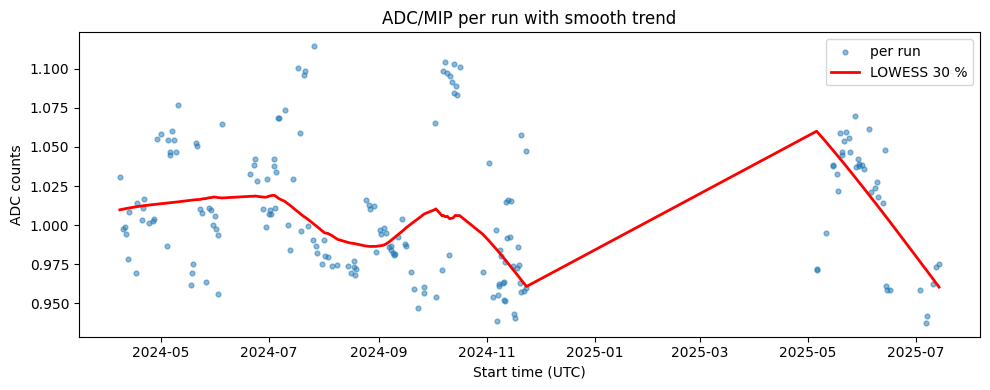

In [55]:
from statsmodels.nonparametric.smoothers_lowess import lowess

x = pd.to_datetime(df['start_ms'], unit='ms')
y = df['adc_mip'].values
# LOWESS with 30 % span
low = lowess(y, x.astype(int), frac=0.3, return_sorted=False)

plt.figure(figsize=(10,4))
plt.scatter(x, y, s=12, alpha=0.5, label='per run')
plt.plot(x, low, color='red', lw=2, label='LOWESS 30 %')
plt.title("ADC/MIP per run with smooth trend")
plt.ylabel("ADC counts")
plt.xlabel("Start time (UTC)")
plt.legend(); plt.tight_layout()

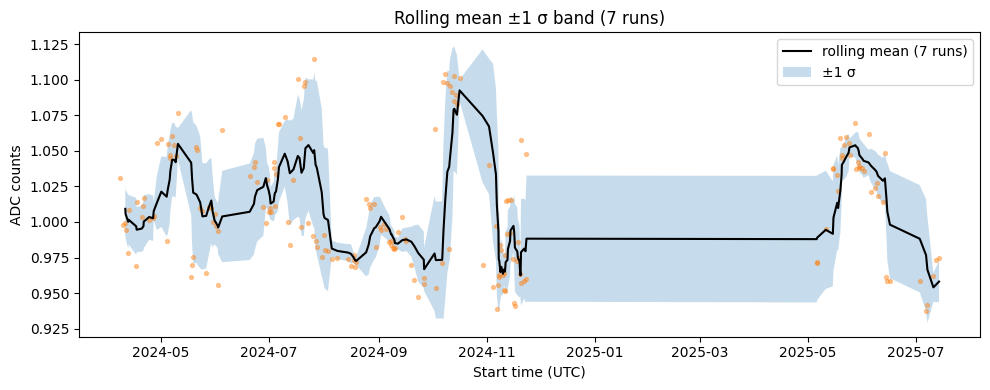

In [56]:
# 7-run rolling statistics
roll_mean  = df['adc_mip'].rolling(7, min_periods=3).mean()
roll_sigma = df['adc_mip'].rolling(7, min_periods=3).std()

plt.figure(figsize=(10,4))
plt.plot(x, roll_mean, color='k', lw=1.5, label='rolling mean (7 runs)')
plt.fill_between(x,
                 roll_mean-roll_sigma,
                 roll_mean+roll_sigma,
                 alpha=0.25, label='±1 σ')
plt.scatter(x, y, s=8, alpha=0.4)
plt.title("Rolling mean ±1 σ band (7 runs)")
plt.ylabel("ADC counts"); plt.xlabel("Start time (UTC)")
plt.legend(); plt.tight_layout()

In [57]:
base = df["adc_mip"].iloc[0]
df["rel_mip"]  = df["adc_mip"] / base
df["rel_err"]  = df["err"]     / base

print("processed runs:", len(df))
df.head()

processed runs: 189


,run,start_ms,adc_mip,err,rel_mip,rel_err
0,549661,1712509984000,1.030860,0.113678,1.000000,0.110275
1,549749,1712639399000,0.997766,0.116775,0.967897,0.113279
2,549824,1712774571000,0.999055,-0.118018,0.969147,-0.114485
3,549853,1712788504000,0.994662,0.116039,0.964885,0.112565
4,549958,1712919188000,0.978508,0.114535,0.949215,0.111106


In [64]:
cut_date = pd.Timestamp("2024-05-01")
mask_time = pd.to_datetime(df["start_ms"], unit="ms") >= cut_date
df = df.loc[mask_time].reset_index(drop=True)

print(f"After cut-off {cut_date.date()}: {len(df)} runs remain "
      f"({df['run'].min()} → {df['run'].max()})")

After cut-off 2024-05-01: 174 runs remain (550897 → 564587)


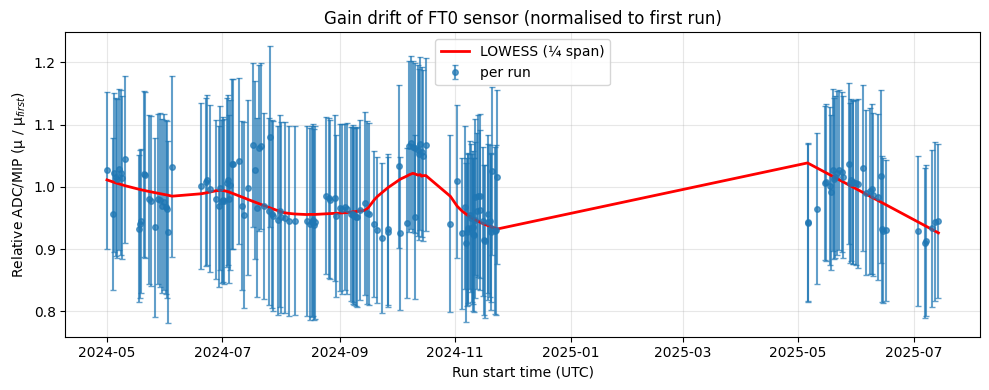

In [65]:
times     = pd.to_datetime(df["start_ms"], unit="ms")

mask      = np.isfinite(df["rel_err"])
plot_x    = times[mask]
plot_y    = df.loc[mask, "rel_mip"]
plot_err  = df.loc[mask, "rel_err"].abs()

plt.figure(figsize=(10, 4))
plt.errorbar(plot_x, plot_y, yerr=plot_err,
             fmt="o", ms=4, capsize=2, alpha=0.7, label="per run")

low = lowess(plot_y, df.loc[mask, "start_ms"], frac=0.25, return_sorted=False)
plt.plot(plot_x, low, color="red", lw=2, label="LOWESS (¼ span)")

plt.ylabel("Relative ADC/MIP (μ / μ$_{first}$)")
plt.xlabel("Run start time (UTC)")
plt.title("Gain drift of FT0 sensor (normalised to first run)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()